# Introductory applied machine learning (INFR10069)

# Assignment 4: Feature Engineering

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.


## Mechanics

You should produce a Jupyter notebook in answer to this assignment.
**You need to submit this notebook electronically as described below.**

Place your notebook in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 4 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers. **You are welcome to split your answer into multiple cells with intermediate printing.**

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [56]:
from __future__ import division #print_function
import os
import math
from collections import OrderedDict
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline

In [2]:
seed = 0
rng = np.random.RandomState(seed=seed)

## Description of the datasets


This assignment is based on two datasets:
1. the 20 Newsgroups Dataset (you should recognise it from Assignment 1)
2. the MNIST digits dataset

### 20 Newsgroups

For convenience, we repeat the description here. This dataset is a collection of approximately **20,000 newsgroup documents**, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are **very closely related** to each other (e.g. comp.sys.ibm.pc.hardware, comp.sys.mac.hardware), while others are **highly unrelated** (e.g misc.forsale, soc.religion.christian). 

To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We will use documents from only **5 out of the 20 newsgroups**, which results in a 5-class problem. More specifically the 5 classes correspond to the following newsgroups: 
1. `alt.atheism`
2. `comp.sys.ibm.pc.hardware`
3. `comp.sys.mac.hardware`
4. `rec.sport.baseball`
5. `rec.sport.hockey `

However, note here that classes **2-3** and **4-5** are rather closely related.

**In contrast to Assignment 1**, we have opted to use **tf-idf** weights ([term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
for each word instead of the frequency counts. These weights represent the importance of a word to a
document with respect to a collection of documents. The importance increases proportionally to the number
of times a word appears in the document and decreases proportionally to the number of times the word
appears in the whole corpus. 

Additionally we preprocess the data to include the **most frequent 1000 words** that are in **greater than 2 documents**, less than half of all documents, and that are not **[stop words](https://en.wikipedia.org/wiki/Stop_words)**.

We will perform all this preprocessing for you.


### MNIST
This MNIST Dataset is a collection handwritten digits. The samples are partitioned (nearly) evenly across the **10 different digit classes {0, 1, . . . , 9}**. We use a preprocessed version for which the data are **$8 \times 8$** pixel images containing one digit each. For further details on how the digits are preprocessed, see the sklearn documentation. The **images are grayscale**, with each pixel taking values in **{0, 1, . . . , 16}**, where 0 corresponds to black (weakest intensity) and 16 corresponds to white (strongest intensity). Therefore, the dataset is a **N × 64** dimensional matrix where each dimension corresponds to a pixel from the image and N is the number of
images. 

Again, to save you time, we perfom the import for you.

## 1. Clustering the 20 Newsgroups Data [50%]

In part 1 we will cluster the observations in the 20 Newsgroups dataset using the k-means algorithm. Each row of the dataset represents a document with bag of words features. If we were not given the labels for each document (i.e. the newsgroup it came from), clustering could allow us to infer which documents should have the same label. Observing common words within each cluster may allow us to give meaning to these inferred labels too.

First we'll import the data and fit and evaluate k-means with 5 cluster centres. Next, we will try and infer which cluster corresponds with which label. Finally, we will pretend we don't know the number of clusters there should be, as is the normal scenario with large unlabeled data, and investigate the effect of using a different number of cluster centres (i.e. varying `k`).

### ========== Question 1.0 ==========

Run the below cells to import the data. It would be a good idea to understand the code but it's not strictly necessary (see the [sklearn documentation](http://scikit-learn.org/0.17/datasets/index.html#the-20-newsgroups-text-dataset)).

*This may take a wee while as it will download the dataset*

**Do not change any of the code in this question**

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

cats = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
        'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, 
                                      remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english', 
                             token_pattern='(?u)\\b[A-z]{2,}\\b')
X_sparse = vectorizer.fit_transform(newsgroups_train.data)
y_num = newsgroups_train.target
X = pd.DataFrame(X_sparse.todense(), columns=vectorizer.get_feature_names())
y = np.array(cats)[y_num]

### ========== Question 1.1 ==========

Perform an initial inspection of the data, X and y (no more than 5 lines of code). Below the code, describe what the data are i.e. what the objects are, and what they represent (fewer than 4 sentences).

In [4]:
X[:5]

,abc,ability,able,ac,accept,access,according,acquired,actually,adaptec,...,written,wrong,yankees,yeah,year,years,yes,york,young,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X[-5:]

,abc,ability,able,ac,accept,access,according,acquired,actually,adaptec,...,written,wrong,yankees,yeah,year,years,yes,york,young,zone
2840,0.0,0.0,0.0,0.0,0.155859,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2841,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2842,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2843,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2844,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.23755,0.0,0.0,0.0


In [6]:
# Your code goes here
X.describe()

,abc,ability,able,ac,accept,access,according,acquired,actually,adaptec,...,written,wrong,yankees,yeah,year,years,yes,york,young,zone
count,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,...,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000
mean,0.002436,0.002149,0.006709,0.001454,0.002286,0.003953,0.003115,0.000921,0.008366,0.001816,...,0.002612,0.006811,0.002470,0.003564,0.016934,0.008797,0.006381,0.002772,0.003288,0.001626
std,0.030224,0.020739,0.034631,0.023100,0.021634,0.030111,0.026958,0.016275,0.043921,0.026026,...,0.026988,0.039172,0.032786,0.031238,0.061181,0.039346,0.037319,0.025381,0.030929,0.022175
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.723914,0.420916,0.431380,0.519765,0.443354,0.663808,0.572124,0.413233,1.000000,0.578282,...,0.723081,0.568146,0.878185,0.693531,0.650649,0.455493,0.646447,0.572455,0.703771,0.605576


In [7]:
y[:10]

array(['rec.sport.baseball', 'rec.sport.baseball', 'rec.sport.hockey',
       'comp.sys.ibm.pc.hardware', 'rec.sport.baseball', 'alt.atheism',
       'comp.sys.mac.hardware', 'rec.sport.hockey', 'alt.atheism',
       'rec.sport.baseball'], 
      dtype='|S24')

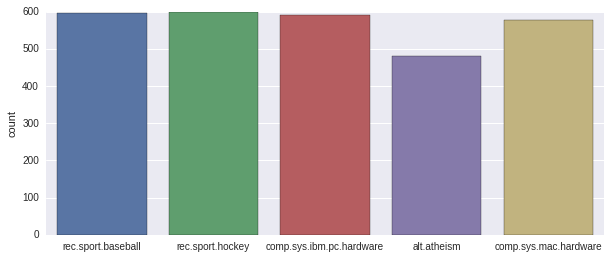

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
sns.countplot(y, ax=ax)

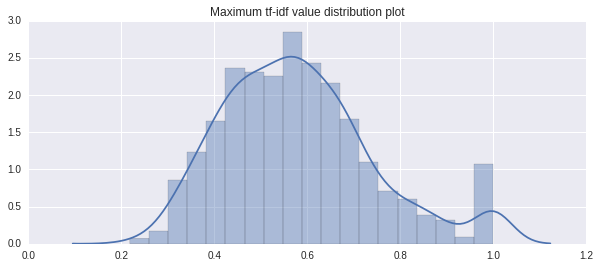

In [9]:
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(np.max(X,axis=0), ax=ax)
ax.set_title('Maximum tf-idf value distribution plot')

In [10]:
#get all the columns where they contain a maximum value of 1
columnIndices = np.argwhere(np.max(X, axis=0) == 1)
columnNames = [c[0] for c in X.columns[columnIndices]]

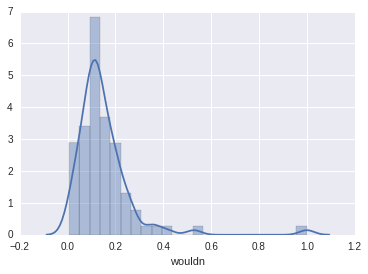

In [11]:
#all values of first column where the maximum value is 1 and whose values are not zero
values = X[columnNames[-1]][X[columnNames[-1]] != 0]
sns.distplot(values)

In [12]:
math.log(len(X)/2)

7.260171166000486

???

Plotting distributions like the above one (not plotting all of them not to clutter the space) gives the conclusion that having a tf-idf value of 1 is highly unlikely.

Because if idf can only get as a maximum value the log of the size of our corpus divided by two which is smaller than 8 and even if we had included all of the 20.000 documents we would still have the idf to have a maximum value of less than 10.

Let's say that idf has the extreme value of 10.  
So in order to get tf-idf = 1 the tf must be 1/10 and we must have a word in a document appear 10% of the time which is quite high.

*Your answer goes here*

Here we see that we have 1000 words as features for each document.

We also see that the data is quite sparse meaning that only a few of the words actually appear on each document.

We have removed too common words like "the", "to", etc. which are more related to the structure of the english language rather than the document itself.

We have used Tf-Idf to give less "weight" to the words who are common among all of the documents of our corpus and give more "weight" to the words who are distinctive for each document and also appear regularly in the document.

By plotting the countplot we see that the classification is a balanced one which makes it easier for our machine learning algorithms.

### ========== Question 1.2 ==========

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 5 clusters. Make sure that you can reproduce your results exactly. *Hint: there is an argument for this*. You need only set two arguments; others can be kept as default. Call the instantiated object `kmeans`. Use the `fit()` method to fit to the training data (X imported above)

In [13]:
numOfClusters = len(np.unique(y))
assert numOfClusters == 5

In [14]:
# Your code goes here
kmeans = KMeans(n_clusters=numOfClusters, random_state=seed).fit(X)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

### ========== Question 1.3 ==========

Evauate the quality of this fit.

1. Get a feel for the average distance of a data point from the centre: print the mean of the euclidean distances of all data points from the mean data point (in the whole dataset)
1. print the inertia of the model. *Hint: check the properties of the kmeans object*
1. print the adjusted rand index of the model. *Hint: `adjusted_rand_score`*

Below the code: 
1. Define what the inertia and adjusted rand score are (one or two sentences). *Hint: check [sklearn documentation](http://scikit-learn.org/stable/modules/clustering.html)*
1. Comment on the quality of the clustering implied by the adjusted rand score and inertia

In [15]:
# Your code goes here


#### 1. Get a feel for the average distance of a data point from the centre

In [16]:
Xs = []
for i in range(numOfClusters):
    Xs.append(X[kmeans.labels_ == i])

In [17]:
assert np.sum([len(t) for t in Xs]) == len(X), "just verifying we did the correct assignments"

In [18]:
def getAverageDistanceOfClusterFromCenter(cluster, clusterCenter):
    #return np.mean(np.sqrt(np.sum((cluster.values - clusterCenter)**2, axis=1)))
    return np.mean(euclidean_distances(cluster, clusterCenter[np.newaxis]))

In [19]:
averageDists = []
for i in range(numOfClusters):
    cluster = Xs[i]
    clusterCenter = kmeans.cluster_centers_[i]
    averageDists.append(
        getAverageDistanceOfClusterFromCenter(cluster, clusterCenter)
    )
    
averageDists

[0.89623738778879503,
 0.93085816833663448,
 0.95996247170756344,
 0.9663330596155717,
 0.97480902380173606]

It happens that the distance is increasing. We consider this a coincidence.

The first cluster is more dense since it has points closer to the center with smaller average distance.

The fifth cluster is less dense since it has points further away from the center with larger average distance.

In [20]:
#math.sqrt(np.sum( (cluster.values - clusterCenter)**2))
sum(averageDists)

4.7282001112503007

#### 2. inertia of the model

In [21]:
kmeans.inertia_

2593.2674510604393

In [22]:
def getSumOfSquaredDists(cluster, clusterCenter):
    return np.sum((cluster.values - clusterCenter)**2)

In [23]:
inertia = 0
for i in range(numOfClusters):
    inertia += getSumOfSquaredDists(cluster = Xs[i], clusterCenter = kmeans.cluster_centers_[i])
    
inertia

2593.2674510604393

#### Adjusted Rand Index

In [24]:
adjusted_rand_score(y, kmeans.labels_)

0.23645935852854669

*Your answer goes here*

**Inertia** is the squared difference between the points and the center. We have included extra code above to prove that. Here we have different dimensionality and a different dataset and therefore we cannot have any solid arguments of whether this inertia is good or bad in comparison with other clustering we have done in the past.

**Adjusted Rand Score** is measuring the similarities between two assignments and in addition it normalized to get values from 1 which is perfect similarity to 0 or slightly negative values for bad similarities.

The Adjusted Rand Score is useful because it does not care how the two sets under comparison are being represented. The various instances could be represented by strings or numbers but what it only matters is the number of pairs of elements that are in the same set in C and in the same set in K and the number of pairs of elements that are in different sets in C and in different sets in K.

Adjusted Rand Score is symmetric which means that it does not matter whether if you compare A with B or B with A.

### ========== Question 1.4 ==========

Print:
1. the number of datapoints with each label
2. the number of datapoints assigned to each cluster. *Hint: you should use the properties of the kmeans object you just fit.* 

Below the code, comment on the distribution of datapoints to cluster centres.

In [25]:
# Your code goes here
classesDict = OrderedDict()
for cls in np.unique(y):
    classesDict[cls] = len(y[y==cls])
    print "for %s we have %d instances" % (cls, classesDict[cls])

for alt.atheism we have 480 instances
for comp.sys.ibm.pc.hardware we have 590 instances
for comp.sys.mac.hardware we have 578 instances
for rec.sport.baseball we have 597 instances
for rec.sport.hockey we have 600 instances


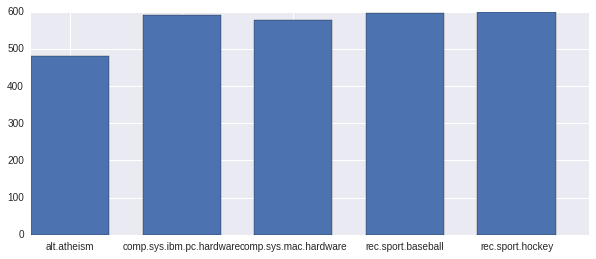

In [26]:
fig, ax = plt.subplots(figsize=(10,4))
width=0.7
xaxis = np.arange(len(classesDict))
plt.bar(xaxis,classesDict.values(), width=width)
ax.set_xticks(xaxis + width / 2)
ax.set_xticklabels(classesDict.keys())
print

In [27]:
lbs = kmeans.labels_
clustersDict = OrderedDict()
for i in range(kmeans.n_clusters):
    clustersDict["cluster" + str(i)] = len(lbs[lbs==i])
    print "for cluster %d we have %d points" % (i, clustersDict["cluster" + str(i)])

for cluster 0 we have 1028 points
for cluster 1 we have 221 points
for cluster 2 we have 307 points
for cluster 3 we have 601 points
for cluster 4 we have 688 points


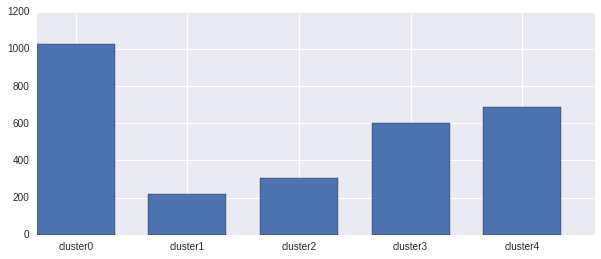

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
width=0.7
xaxis = np.arange(len(clustersDict))
plt.bar(xaxis,clustersDict.values(), width=width)
ax.set_xticks(xaxis + width / 2)
ax.set_xticklabels(clustersDict.keys())
print

*Your answer goes here*

We see that some clusters are more dominant in comparison to other clusters and the distribution is quite different from our original distribution of the classes of the documents which is quite balanced.

The k-means clustering produced an imbalanced distribution with the cluster 0 "gathering" a lot of the points

### ========== Question 1.5 ==========

We can't visualise these cluster centres directly, since they are 1000 dimensional. However, we can at least measure the distance between each centre. Create a distance matrix such that the entry with index (i,j) shows the distance between centre i and j. *Hint: again you should use the properties of the kmeans object you just fit.*

In [29]:
# Your code goes here
Xtransf = kmeans.transform(X)
Xtransf.shape

(2845, 5)

In [30]:
#just some assertions to verify that transform does exactly what we expect that it does
for i in range(numOfClusters):
    assert Xtransf[0, i] == euclidean_distances(X[:1], kmeans.cluster_centers_[i][np.newaxis])[0][0]

You may ignore the two cell above. Might not be necessary below

In [31]:
def getEuclideanDistance(a, b):
    assert len(a.shape) == 1 and len(b.shape) == 1, "use euclidean_distances if you want euclidean distances across a matrix"
    return np.sqrt(np.sum((a - b)**2))

In [32]:
centroidDist = -np.ones((numOfClusters, numOfClusters))

for i in range(numOfClusters):
    for j in range(numOfClusters):
        centroidDist[i,j] = getEuclideanDistance(kmeans.cluster_centers_[i], kmeans.cluster_centers_[j])
        
centroidDist

array([[ 0.        ,  0.34374521,  0.23330485,  0.20265703,  0.18763549],
       [ 0.34374521,  0.        ,  0.41216404,  0.4076788 ,  0.32073454],
       [ 0.23330485,  0.41216404,  0.        ,  0.29943647,  0.29271357],
       [ 0.20265703,  0.4076788 ,  0.29943647,  0.        ,  0.28842491],
       [ 0.18763549,  0.32073454,  0.29271357,  0.28842491,  0.        ]])

### ========== Question 1.6 ==========

For each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Below the code, comment on the quality of the fit. *Hint: you can do the main plot (without labels) in one line with seaborn (you're free to do it as you like though!).*

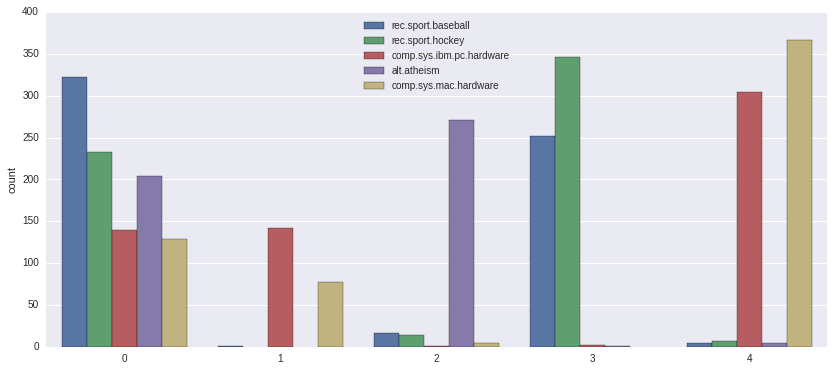

In [33]:
# Your code goes here
fig, ax = plt.subplots(figsize=(14,6))
sns.countplot(kmeans.labels_, hue=y, ax=ax)
#sns.countplot(kmeans.labels_, hue=y)

*Your answers goes here*

We see that the only cluster that can be characterized as pure is the cluster 2.  
Almost all of the instances of the cluster 2 belong to alt.atheism document category and we can be sure that if a new instance belongs to cluster 2 that we can classify it as alt.atheism

As far as the classes/categories are concerned there is no category that belongs only to one cluster and no other cluster. Most documents of the same category belong to two or more clusters. For example the instances of the category comp.sys.ibm.pc.software belongs to cluster 0, cluster 1 and cluster 4.

However we know in advance that comp.sys.ibm.pc.software and comp.sys.mac.hardware document categories are highly related to each other therefore it makes to see cluster 4 and cluster 1 to share these two categories is very similar proportions.

The same argument holds for the categories rec.sport.baseball and rec.sport.hockey where they are represented both in cluster 3.

Similarly since alt.atheism is highly unrelated with all the rest of the categories has its own cluster, cluster number 2.

However it seems that all of these documents have some similarities among each other and these similarities are apparent in cluster 0 which contains the largest count of all the documents. Intuitively we can express that our process, including tf-idf, euclidean distances and k-means algorithm, is not enough to distinguish documents together. Meaning that all documents cluster around cluster 0 and only the ones that are more distinctive, more special are able to distinguish themselves to gather around other the rest of the four clusters.

### ========== Question 1.7 ==========

We will now investigate using dimensionality reduction to try and improve the quality of the fit. Use the sklearn implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to create a reduced reduced dataset for `n_components` = [1,2,3,5,10,20,50,100,500,1000] i.e. create datasets that are of shape `(N, d)` for `d` in `n_components`. Fit k-means to each reduced dataset and report the `inertia` and `adjusted_rand_score` for each iteration.

Plot `adjusted_rand_score` against number of principal components (label graph). Use a log scale on the x axis. Below the graph:
1. describe what it shows
1. explain why we cannot use inertia to choose the best number of principal components
1. explain why dimensionality reduction could help k-means perform better

In [34]:
nComponentsCollection = [1,2,3,5,10,20,50,100,500,1000]

In [35]:
# Your code goes here
pcas = [PCA(n_components=nComponents, random_state=seed) for nComponents in nComponentsCollection]
pcas

[PCA(copy=True, iterated_power='auto', n_components=1, random_state=0,
   svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=2, random_state=0,
   svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
   svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
   svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=10, random_state=0,
   svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=20, random_state=0,
   svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=50, random_state=0,
   svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=100, random_state=0,
   svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=500, ra

In [36]:
Xreduced = [pca.fit_transform(X) for pca in pcas]

*Note that we are not experimenting with the number of clusters. We still have the same goal. To classify the documents to 5 categories as the original ones. So the number of clusters remains five as the number of the original classes*

In [37]:
kmeansCollection = [KMeans(n_clusters=numOfClusters, random_state=seed).fit(x) for x in Xreduced]

In [38]:
inertias = [km.inertia_ for km in kmeansCollection]
inertias

[2.8209066804503609,
 10.577751242211693,
 20.456716888308101,
 49.843760432666741,
 117.83731196617025,
 230.94605077569921,
 488.35937953862322,
 800.80805881663287,
 2132.3533735533051,
 2593.5593003958033]

In [39]:
adjustedRandScores = [adjusted_rand_score(y, km.labels_) for km in kmeansCollection]
adjustedRandScores

[0.21022329338958748,
 0.2681548079895289,
 0.24030341358598753,
 0.22621915785488358,
 0.21636606674724582,
 0.2117376494267805,
 0.22220097719207238,
 0.21381749170180761,
 0.22465988685016111,
 0.22890537097702235]

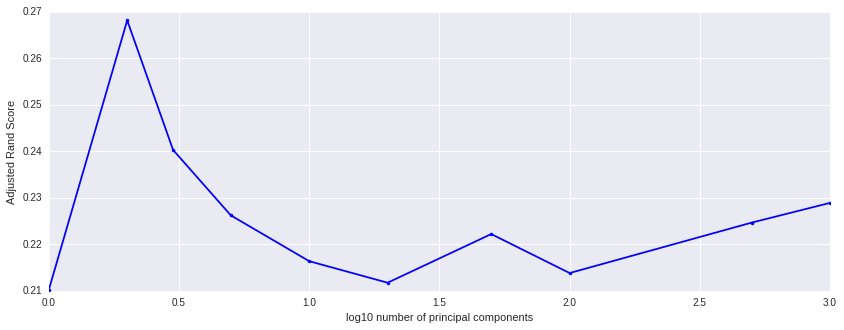

In [40]:
fig, ax = plt.subplots(figsize=(14,5))
plt.plot( np.log10(nComponentsCollection), adjustedRandScores, 'b.-')
plt.xlabel('log10 number of principal components')
plt.ylabel('Adjusted Rand Score')

In [41]:
print "the adjusted rand score is maximum for components of number# :"
nComponentsCollection[np.argmax(adjustedRandScores)]

the adjusted rand score is maximum for components of number# :


2

*Your answer goes here*

1) The graph represents the adjusted rand score for each dimensionality reduction of our original dataset linearly using PCA. We see that the score has a maximum when reduced the dimensionality to only two dimensions


2) We cannot use inertia choose the best principal components because it does not make sense to compare inertia at different dimensionalities. We have to remember that inertia is just the sum of the square differences and these distances are larger for full dimensionality. Since PCA effectively projects points on the hyperplane of maximum variance for every dimensionality reduction the points come closer and closer together and therefore the inertia is meant to be reduced

3) Dimensionality does not always help kmeans perform better. Below there is code that proves that with.  
We have set multivariate gaussians such that on the first example you can have two clusters in 2D but when the PCA projects the points on the axis of highest variance reducing the dimensionality from 2D to 1D then it is apparent that points will fall on top of each other and in 1D then clustering will have a lower adjusted rand score.

On the second example below we see that the two clusters in 2D are very mixed and when projected along the axis of highest variance which is what PCA does then the points on this one-dimension are better separated than before. Something similar must have happened to our dataset but we cannot plot it in 1000 dimensions. That's why it the clustering performs better when dimensions are reduced in only two.

#### My example where dimensionality reduction does NOT help k-means clustering

yy = np.concatenate( ( np.repeat('A', len(xxA1)), np.repeat('B', len(xxB1)) ) )
yy.shape

covA = np.array([[10, 1],
                [1, 10]])
xxA1, xxA2 = rng.multivariate_normal([0, 0], covA, 300).T
covB = np.array([[6.1, -6],
                [-6, 6.1]])
xxB1, xxB2 = rng.multivariate_normal([-2, -5], covB, 300).T
#let's connect together xx2 and yy2 but with different labels
xx = np.hstack( (np.concatenate( (xxA1,xxB1) )[np.newaxis].T, np.concatenate( (xxA2,xxB2) )[np.newaxis].T ) )
xx.shape

#fig = plt.figure()
plt.hold(True)
plt.scatter(xxA1, xxA2, alpha=0.5, c='b')
plt.scatter(xxB1, xxB2, alpha=0.5, c='g')
plt.hold(False)
plt.legend( ('Alpha', 'Beta') )
plt.show()

adjusted_rand_score(yy, KMeans(n_clusters=2, random_state=seed).fit(xx).labels_)

xx1D = PCA(n_components=1, random_state=seed).fit_transform(xx)
print xx1D.shape
adjusted_rand_score(yy, KMeans(n_clusters=2, random_state=seed).fit(xx1D).labels_)

#### My example where dimensionality reduction DOES help k-means clustering

xxA1, xxA2 = rng.multivariate_normal([0, 0], np.array([[1.5, 1],
                                                       [1, 1.5]]), 300).T

xxB1, xxB2 = rng.multivariate_normal([-2, 0], np.array([[1.1, -1],
                                                        [-0.9, 1.1]]), 300).T

xx = np.hstack( (np.concatenate( (xxA1,xxB1) )[np.newaxis].T,
                 np.concatenate( (xxA2,xxB2) )[np.newaxis].T ) )

#fig = plt.figure()
plt.hold(True)
plt.scatter(xxA1, xxA2, alpha=0.5, c='b')
plt.scatter(xxB1, xxB2, alpha=0.5, c='g')
plt.hold(False)
plt.legend( ('Alpha', 'Beta') )
plt.show()

adjusted_rand_score(yy, KMeans(n_clusters=2, random_state=seed).fit(xx).labels_)

xx1D = PCA(n_components=1, random_state=seed).fit_transform(xx)
print xx1D.shape
adjusted_rand_score(yy, KMeans(n_clusters=2, random_state=seed).fit(xx1D).labels_)

### ========== Question 1.8 ==========

1. So we can visualise the data, create X_2d: the dataset X transformed down to 2 principal component dimensions. Use sklearn's implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to do this (as above). 

1. Create a new k-means object, `kmeans_pca`, and fit the 2d data to it. Show the adjusted rand score.

1. As above, for each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Print below it the number of data points each cluster is responsible for.

1. Finally, below the plot, comment on the difference between these clusters and the clusters on the 1000 dimensional data with respect to the distribution of the labels in each. Are they better?

#### 1.

In [42]:
X_2d = PCA(n_components=2, random_state=seed).fit_transform(X)
print X_2d.shape

(2845, 2)


#### 2.

In [43]:
kmeans_pca = KMeans(n_clusters=numOfClusters, random_state=seed).fit(X_2d)
print "adjusted rand score for 1000 to 2 dimensionality reduction is"
print adjusted_rand_score(y, kmeans_pca.labels_)

adjusted rand score for 1000 to 2 dimensionality reduction is
0.26815480799


#### 3.

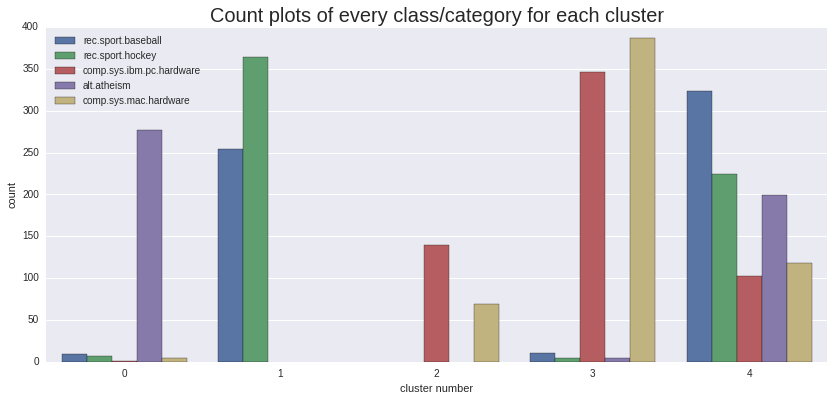

In [44]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_title('Count plots of every class/category for each cluster', fontsize=20)
ax.set_xlabel('cluster number')
sns.countplot(kmeans_pca.labels_, hue=y, ax=ax)

#### 4.

*Your answer goes here*

We see that we have a cluster for atheism as before. We also see the pattern where the similar categories belong in the same cluster meaning that pc.hardware and mac.hardware are both found in cluster 3 and cluster 2.

We have a cluster number 4 which contains documents from all the categories.

In general we cannot see any real improvement on this diagram.

### ========== Question 1.9 ==========

Given the above plot, apply a label to each cluster centre. Create a new vector, `labels_interp`, which is the same as `kmeans.labels_`, but instead of numbers, the interpreted label of the cluster centre. For example, if you decided cluster 0 was 'apples', 1 was 'pears', 2 was 'stairs', and `kmeans.labels_` was `[2, 0, 1, 1, 0]`, create  `labels_interp = ['stairs', 'apples', 'pears', 'pears', 'apples']`. Hint: an example of how to do this is given in the last line of Question 1.0.

**N.B. be careful to use the `kmeans_pca` object you created above, not the first kmeans object you made**

In [80]:
cats

['alt.atheism',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'rec.sport.baseball',
 'rec.sport.hockey']

In [81]:
#clusterNames = np.array(['atheism', 'sports', 'pchardware', 'machardware', 'alltopics'])
clusterCats = np.array(['alt.atheism',
                        'rec.sport.hockey',
                        'comp.sys.ibm.pc.hardware',
                        'comp.sys.mac.hardware',
                        'rec.sport.baseball'])

In [82]:
# Your code goes here
#labels_interp = clusterNames[kmeans_pca.labels_]
labels_interp = clusterCats[kmeans_pca.labels_]
print labels_interp[:10]
print kmeans_pca.labels_[:10]

['rec.sport.baseball' 'rec.sport.hockey' 'rec.sport.hockey'
 'comp.sys.mac.hardware' 'rec.sport.hockey' 'rec.sport.baseball'
 'rec.sport.baseball' 'rec.sport.baseball' 'alt.atheism' 'rec.sport.hockey']
[4 1 1 3 1 4 4 4 0 1]


### ========== Question 1.10 ==========

Produce a normalised (by true label) confusion matrix of your interpreted labels from the k-means clustering and the true labels. As usual, you may use any functions from previous assignments or labs. Clearly label the axes of the plot. Check that these confusions correlate with your expectations! N.B. this is just a slightly different way of interpreting the information in the count plot above (focussed this time on the true labels).

In [84]:
def howEachClassHasBeenClassified(confusionMatrix):
    return (confusionMatrix.T / np.sum(confusionMatrix, axis=1)).T

In [85]:
def getNormalizedConfusionMatrix(realTargets, predictions):
    return howEachClassHasBeenClassified(
        confusion_matrix(y_true=realTargets, y_pred=predictions)
    )

In [86]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Better convert the y and our cluster assignments from strings back to number to be able and have a robust confusion matrix without any worrying of how seaborn handles categorical data

In [111]:
categDict = {
    'alt.atheism': 0,
    'rec.sport.hockey': 1,
    'rec.sport.baseball': 2,
    'comp.sys.ibm.pc.hardware': 3,
    'comp.sys.mac.hardware': 4,
}

In [113]:
yNumeric = [categDict[t] for t in y]
predictionsNumeric = [categDict[t] for t in labels_interp]

In [112]:
categInvDict = dict(zip(categDict.values(), categDict.keys()))
categInvDict

{0: 'alt.atheism',
 1: 'rec.sport.hockey',
 2: 'rec.sport.baseball',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware'}

In [116]:
categInvArr = [categInvDict[i]  for i in range(len(categInvDict))]
categInvArr

['alt.atheism',
 'rec.sport.hockey',
 'rec.sport.baseball',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware']

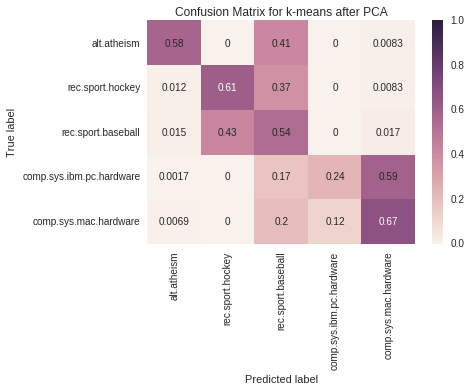

In [118]:
plot_confusion_matrix(getNormalizedConfusionMatrix(
        realTargets=yNumeric,
        predictions=predictionsNumeric),
        classes = categInvArr,
        title='Confusion Matrix for k-means after PCA'
)

Yes this is what we are expecting as above. We have the *baseball* cluster take up a significant proportion of the true documents for all categories which is in concise with the countplot above where we see significant amount of bars from all categories.

From the confusion matrix we can immediately distinguish that *pc hardware* and *mac hardware* are being confused since oc hardware is confused as mac hardware 59% of the time and this is due to our decision to assign the clusters such that the mac is favored. We see here that only 12% of the time the mac hardware is confused as a pc hardware.

We notice the same picture between sports documents. Baseball is classified as baseball 54% of the time while it is confused as hockey 43% of the time. Hockey is confused being baseball equally as high, 37% of the time.

Atheism is confused as baseball 41% of the time because this is a "bad" cluster in terms of the classification that we want to make since the baseball cluster really should have been named "all topics" because it contains documents from all topics with significant proportion from each.

### ========== Question 1.11 ==========

Since we are now in 2 dimensions, let's visualise the data, the cluster centres, and the decision boundaries via a [Voronoi_diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). You'll essentially be able to copy and paste the code from the [sklearn kmeans digits example](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) and edit a few bits to get over half marks.

Clearly mark each cluster centre.

For full marks, additionally:
* label each cluster centre with the inferred cluster label
* create a second plot which clearly shows where the true classes lie within the pca space e.g. the [sklearn PCA example here](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)

In [165]:
# Your code goes here

def plotVoronoiDiagram(reduced_data, kmeans, clusterCategories = None):
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 0.1, reduced_data[:, 0].max() + 0.1
    y_min, y_max = reduced_data[:, 1].min() - 0.1, reduced_data[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig = plt.figure(1)
    #F = pylab.gcf()
    fig.set_figwidth(16)
    fig.set_figheight(7)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    
    if clusterCategories is not None:
        fontdict = {
            'family': 'sans-serif',
            'color':  'white',
            'weight': 'normal',
            'size': 16,
            'ha': 'center'
        }
        for i in range(len(centroids)):
            plt.text(centroids[i, 0], centroids[i, 1], clusterCategories[i],fontdict=fontdict)
    
    plt.show()

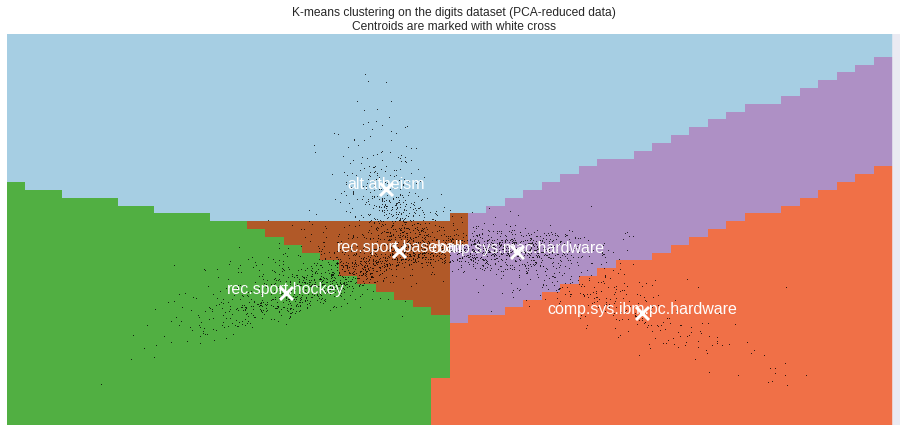

In [167]:
# fig = plt.figure(1)
# fig.set_figwidth(12)
# fig.set_figheight(5)
plotVoronoiDiagram(X_2d, kmeans_pca, clusterCats)

???

### ========== Question 1.12  ==========

*Write a **1 or 2 sentence** answer for each question*.

1. Is the kmeans algorithm deterministic?
1. Did the algorithm you ran above in Question 1.2 (fitting k-means) do multiple initialisations? If not, explain why it was not necessary. If so, how was the final model selected?
1. The default method for initialising centres in the sklearn implementation is [kmeans++](https://en.wikipedia.org/wiki/K-means%2B%2B). Name another method for initialising and a problem with it.

*Your answer goes here*

#### 1.
No it is not deterministic. Here we have used a static seed for our random initializer to get reproducable results but in general k-means is dependent to converge according to where the initial points lie. There are local minimas.

#### 2.
Checking the defaults of the parameters of the kmeans we see that n_init = 10. Which means that yes we have multiple initializations. Ten of them. 
And from the documentation we quote: "Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia."

Since we have the same number of clusters and the same dimensionality inertia is an appropriate metric to compare among the different models. Therefore the final model and its centroids are chosen to be the best of these ten repetitions, the rest are being discarded

#### 3.

Another method for iniliazing the centroids of the clusters is by random initialization. An example which shows that this might lead to very bad data is mentioned in the Lectures and the same example is mentioned in wikipedia in the following link: https://en.wikipedia.org/wiki/K-means%2B%2B in the section **Example of a sub-optimal clustering** where we quote: "Consider the example of four points in R2 that form an axis-aligned rectangle whose width is greater than its height. If k = 2 and the two initial cluster centers lie at the midpoints of the top and bottom line segments of the rectangle formed by the four data points, the k-means algorithm converges immediately, without moving these cluster centers. Consequently, the two bottom data points are clustered together and the two data points forming the top of the rectangle are clustered together—a suboptimal clustering because the width of the rectangle is greater than its height."

From the above example is apparent that two clusters of two points each, a very simple case, that can easily be distinguished with a bare eye fail to be clustered properly by kmeans. In fact on this case k-means combines two points far away from each other and fails to cluster points that are close together.

## 2. PCA with MNIST Data [50%]

In the second part of the assignment we will explore the MNIST digits dataset. We expect the digits to lie in a lower-dimensional manifold and want to examine the representation we get by applying Principal Components Analysis (PCA). PCA maps the data into a new space by effectively rotating the base vectors of the input space to the directions with the highest variance. We will assess the impact of this mapping to the classification task and the separability of the data in the PCA space.

### ========== Question 2.0 ==========

Run the cell below to load the digits object and print its description.

**Do not change any of the code in this question**

In [168]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### ========== Question 2.1 ==========

If you execute `digits.keys()`, you'll see this object contains the data, the targets (the labels), and the images (the data reshaped to 8x8 images). More typically the mnist data are [28x28 images](http://yann.lecun.com/exdb/mnist/), but this is a preprocessed version. 

1. Use the pandas describe method on the data to get a feel for the range of each dimension
1. Print the max/min values for each dimension
1. Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use `sns.heatmap()`) to show you which dimensions vary the most. For a bonus mark, produce a plot like this for each digit. *Hint: you can use `.groupby(digits.target)` before calling `.describe()`*.
1. Use `sns.heatmap()` to plot the first 9 digits in the dataset

Below the plots:
1. Are all of the dimensions going to be equally helpful for modelling? Explain.

#### 1.

In [170]:
# Your code goes here
digits.keys()

['images', 'data', 'target_names', 'DESCR', 'target']

In [178]:
digits.images.shape

(1797, 8, 8)

So here we have lots of images where each one is 8x8 but pandas will not work with 3d arrays

In [179]:
shape = digits.images.shape[:1] + (digits.images.shape[1] * digits.images.shape[2],)

In [180]:
flatImages = np.reshape(digits.images, shape )

In [181]:
pd.DataFrame(flatImages).describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


In [185]:
digits.data.shape

(1797, 64)

In [195]:
mnistData = pd.DataFrame(digits.data)
mnistData.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


In [187]:
assert np.all(flatImages == digits.data), "verifying that our flatImages constructed above are actually the digits.data"

Since digits.images and digits.data are actually the same data only reshaped we are going to deal with only one of them each time

In [188]:
digits.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

So target names are the different kind of targets we can have and is from 0 to 9, all the digits of a base10 system as expected

In [189]:
digits.DESCR

"Optical Recognition of Handwritten Digits Data Set\n===================================================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 5620\n    :Number of Attributes: 64\n    :Attribute Information: 8x8 image of integer pixels in the range 0..16.\n    :Missing Attribute Values: None\n    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n    :Date: July; 1998\n\nThis is a copy of the test set of the UCI ML hand-written digits datasets\nhttp://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n\nThe data set contains images of hand-written digits: 10 classes where\neach class refers to a digit.\n\nPreprocessing programs made available by NIST were used to extract\nnormalized bitmaps of handwritten digits from a preprinted form. From a\ntotal of 43 people, 30 contributed to the training set and different 13\nto the test set. 32x32 bitmaps are divided into nonoverlapping blocks of\n4x4 and the number of on pixels are counted 

digits.DESCR is merely a string with the description

In [190]:
digits.target.shape

(1797,)

In [191]:
pd.DataFrame(digits.target).describe()

,0
count,1797.000000
mean,4.490818
std,2.865304
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


Here the describe shows us that our classification task is a balanced one since we see that 0-9 are approximatelly equally distributed among the dataset. It is easy to see that because our classes are from 0 to 9 which are numbers that are continuously increasing. As an example if the classes were imbalanced we would have at 50% the number 1 for example meaning that we would have lots of ones and/or zeros.

#### 2.

The only thing that makes sense to plot the minimum and maximum value is the mnist data

In [193]:
np.max(digits.data, axis=0)

array([  0.,   8.,  16.,  16.,  16.,  16.,  16.,  15.,   2.,  16.,  16.,
        16.,  16.,  16.,  16.,  12.,   2.,  16.,  16.,  16.,  16.,  16.,
        16.,   8.,   1.,  15.,  16.,  16.,  16.,  16.,  15.,   1.,   0.,
        14.,  16.,  16.,  16.,  16.,  14.,   0.,   4.,  16.,  16.,  16.,
        16.,  16.,  16.,   6.,   8.,  16.,  16.,  16.,  16.,  16.,  16.,
        13.,   1.,   9.,  16.,  16.,  16.,  16.,  16.,  16.])

In [194]:
np.min(digits.data, axis=0)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

We notice that some pixels get the full range of greys from 0 to 16 while on the contrary a few pixels are always black since their max and min value is the same at zero

#### 3.
Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use sns.heatmap()) to show you which dimensions vary the most. For a bonus mark, produce a plot like this for each digit. Hint: you can use .groupby(digits.target) before calling .describe().

In [221]:
stds = mnistData.describe().loc['std']
stds.shape

(64,)

In [222]:
std2D = stds.values.reshape(digits.images.shape[1:])
std2D.shape

(8, 8)

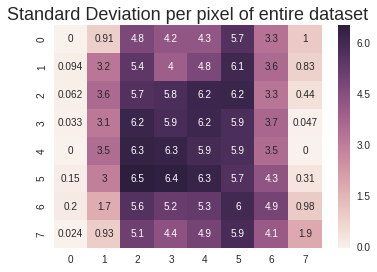

In [232]:
fig, ax = plt.subplots()
sns.heatmap(std2D, annot=True, ax=ax)
ax.set_title('Standard Deviation per pixel of entire dataset', fontsize=18)

In [227]:
descrPerDigit = mnistData.groupby(digits.target).describe()
descrPerDigit

0           1           2           3           4           5   \
0 count  178.0  178.000000  178.000000  178.000000  178.000000  178.000000   
  mean     0.0    0.022472    4.185393   13.095506   11.297753    2.926966   
  std      0.0    0.211400    2.946684    2.246625    3.417485    3.232996   
  min      0.0    0.000000    0.000000    5.000000    0.000000    0.000000   
  25%      0.0    0.000000    2.000000   12.000000    9.000000    1.000000   
  50%      0.0    0.000000    4.000000   13.000000   12.000000    2.000000   
  75%      0.0    0.000000    6.000000   15.000000   14.000000    5.000000   
  max      0.0    2.000000   12.000000   16.000000   16.000000   14.000000   
1 count  182.0  182.000000  182.000000  182.000000  182.000000  182.000000   
  mean     0.0    0.010989    2.456044    9.208791   10.406593    6.076923   
  std      0.0    0.104539    3.452238    5.912841    4.627513    5.727188   
  min      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
  25%      0.0    0.000000    0.000000    3.000000    9.000000    0.000000   
  50%      0.0    0.000000    1.000000   12.000000   12.000000    5.000000   
  75%      0.0    0.000000    4.000000   14.000000   14.000000   11.750000   
  max      0.0    1.000000   16.000000   16.000000   16.000000   16.000000   
2 count  177.0  177.000000  177.000000  177.000000  177.000000  177.000000   
  mean     0.0    0.932203    9.666667   14.186441    9.627119    2.384181   
  std      0.0    1.359283    4.666937    3.130538    5.176098    3.932582   
  min      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
  25%      0.0    0.000000    7.000000   13.000000    5.000000    0.000000   
  50%      0.0    0.000000   10.000000   15.000000   11.000000    0.000000   
  75%      0.0    2.000000   13.000000   16.000000   15.000000    3.000000   
  max      0.0    5.000000   16.000000   16.000000   16.000000   16.000000   
3 count  183.0  183.000000  183.000000  183.000000  183.000000  183.000000   
  mean     0.0    0.644809    8.387978   14.169399   14.224044    7.480874   
  std      0.0    1.053285    3.774883    2.284382    2.460472    4.884199   
  min      0.0    0.000000    0.000000    6.000000    2.000000    0.000000   
  25%      0.0    0.000000    6.000000   13.000000   13.000000    3.000000   
  50%      0.0    0.000000    8.000000   15.000000   15.000000    8.000000   
...        ...         ...         ...         ...         ...         ...   
6 std      0.0    0.000000    1.672568    3.150862    5.256701    2.610610   
  min      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
  25%      0.0    0.000000    0.000000    9.000000    5.000000    0.000000   
  50%      0.0    0.000000    0.000000   12.000000   11.000000    0.000000   
  75%      0.0    0.000000    2.000000   13.000000   14.000000    2.000000   
  max      0.0    0.000000    9.000000   16.000000   16.000000   12.000000   
7 count  179.0  179.000000  179.000000  179.000000  179.000000  179.000000   
  mean     0.0    0.167598    5.100559   13.061453   14.245810   11.027933   
  std      0.0    0.738097    3.722230    3.079767    2.938685    5.481768   
  min      0.0    0.000000    0.000000    3.000000    2.000000    0.000000   
  25%      0.0    0.000000    2.000000   11.000000   14.000000    7.000000   
  50%      0.0    0.000000    4.000000   14.000000   16.000000   13.000000   
  75%      0.0    0.000000    7.500000   16.000000   16.000000   16.000000   
  max      0.0    7.000000   15.000000   16.000000   16.000000   16.000000   
8 count  174.0  174.000000  174.000000  174.000000  174.000000  174.000000   
  mean     0.0    0.143678    5.022989   11.603448   12.402299    6.235632   
  std      0.0    0.512322    4.226197    3.283905    3.822537    4.675195   
  min      0.0    0.000000    0.000000    2.000000    0.000000    0.000000   
  25%      0.0    0.000000    2.000000   10.000000   11.000000    2.000000   
  50%      0.0    0.000000    4.00

In [233]:
std2DPerTarget = [descrPerDigit.loc[i].loc['std'].reshape(digits.images.shape[1:]) for i in digits.target_names]

In [267]:
def getPositionByDigit(digit, subplotsShape):
    subplotPositionPerDigit = digits.target_names.reshape(subplotsShape)
    return np.argwhere(subplotPositionPerDigit == digit)[0]

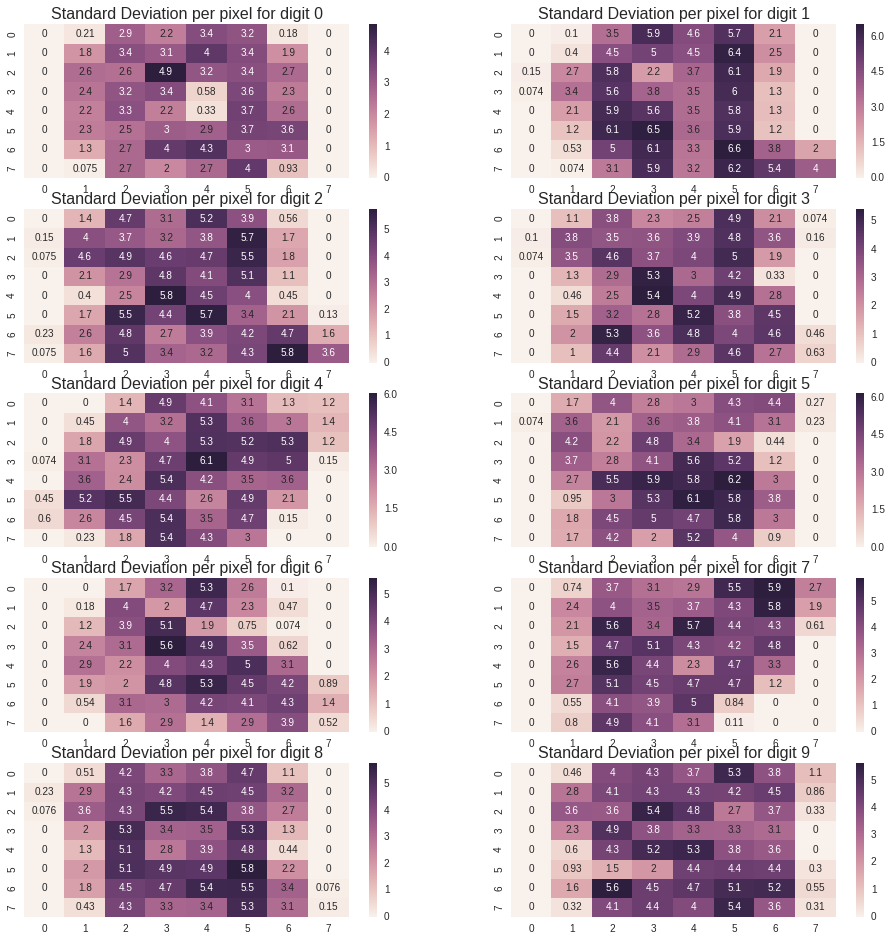

In [269]:
fig, axes = plt.subplots(subplotsShape[0], subplotsShape[1], figsize=(16,16))
for i in digits.target_names: 
    pos = getPositionByDigit(i, subplotsShape)
    curAx = axes[pos[0], pos[1]]
    sns.heatmap(std2DPerTarget[i], annot=True, ax=curAx)
    curAx.set_title('Standard Deviation per pixel for digit %d' % i, fontsize=16)

#### 4.

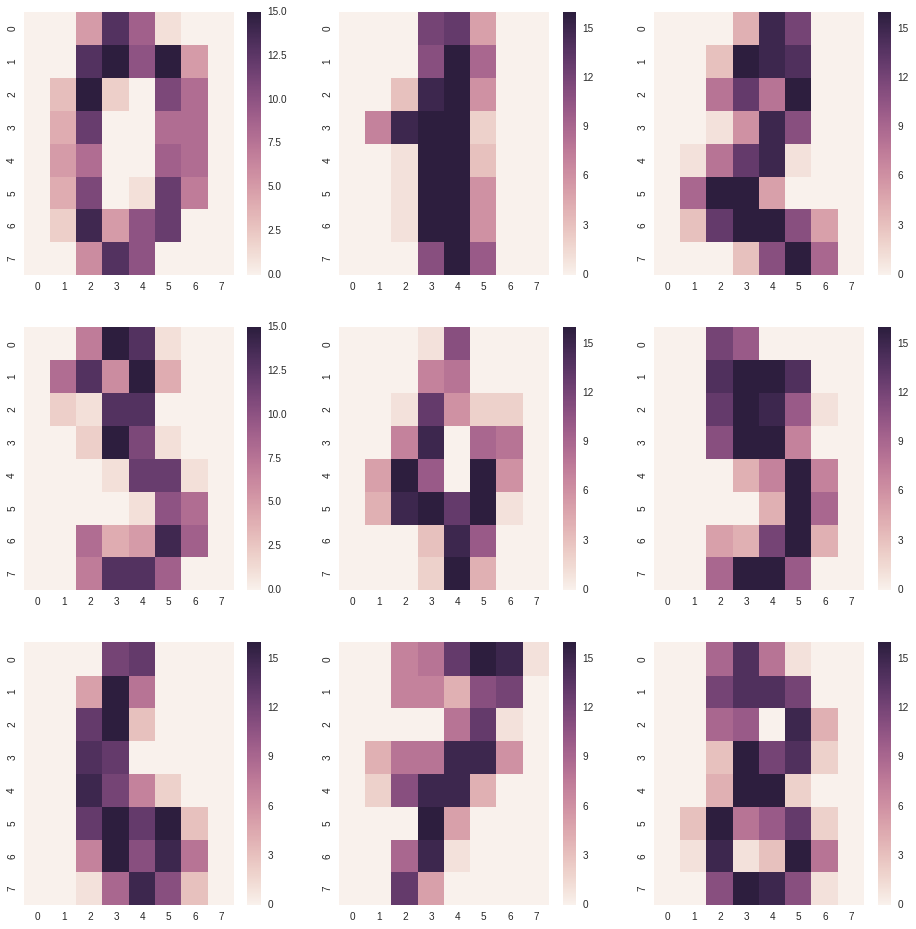

In [283]:
howManyDigits = 9
shape = (int(math.sqrt(howManyDigits)), int(math.sqrt(howManyDigits)))

fig, axes = plt.subplots(shape[0], shape[1], figsize=(16,16))

digitsRange = np.arange(howManyDigits)

for i in digitsRange:
    posMatrix = digitsRange.reshape(shape)
    pos = np.argwhere(posMatrix == i)[0]
    sns.heatmap(digits.images[i], ax=axes[pos[0], pos[1]])

*Your answer goes here*

As we explained above not all dimensions will be needed for modelling because some are always equal to zero no matter what digit they are related to

Let's remove the columns that do not deviate at all and are always zero. We know for sure that these columns do not carry any useful information at all.

In [290]:
mnistAllAttrs = digits.data.copy()
mnistAllAttrs.shape

(1797, 64)

In [291]:
uselessColumns = np.argwhere(np.max(digits.data,axis=0) == 0)

In [295]:
mnistCleanData = np.delete(mnistAllAttrs, uselessColumns, axis=1)
assert mnistCleanData.shape[1] + len(uselessColumns) == mnistAllAttrs.shape[1]

### ========== Question 2.2 ==========

Create a new `PCA` object with `n_components = digits.data.shape[1]`. Plot the explained variance **ratio** against the number of components. You may find [this example](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py) quite handy...

Find the point where 95% of the variance has been explained. Use `plt.vlines()` to add a dotted verical line to the graph at that point and use `plt.annotate()` to label the number of eigenvectors used to explain that variance.

Below the plot, explain what you observe. What does this suggest about the data?

In [296]:
# Your code goes here
pcaFull = PCA(n_components=digits.data.shape[1], random_state=seed)

In [298]:
pcaFull.fit(digits.data)

PCA(copy=True, iterated_power='auto', n_components=64, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

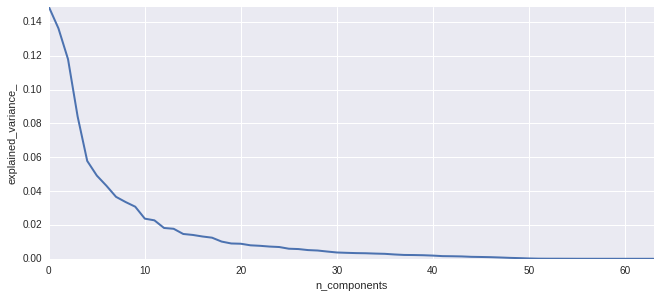

In [316]:
plt.figure(1, figsize=(12, 5))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pcaFull.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [317]:
explainedVariancePercentage = 0
pointWherVarExplainedOver95percent = -1
while explainedVariancePercentage < 0.95:
    explainedVariancePercentage += pcaFull.explained_variance_ratio_[i]
    pointWherVarExplainedOver95percent += 1

In [318]:
pointWherVarExplainedOver95percent

30

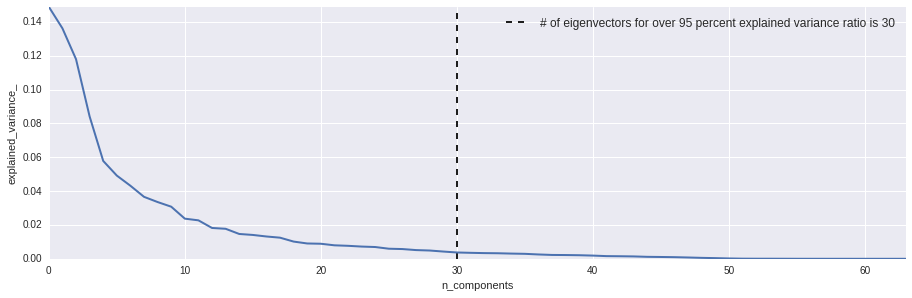

In [330]:
plt.figure(1, figsize=(17, 5))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.hold(True)
plt.plot(pcaFull.explained_variance_ratio_, linewidth=2)
plt.vlines(pointWherVarExplainedOver95percent,
           ymin=min(pcaFull.explained_variance_ratio_),
           ymax= max(pcaFull.explained_variance_ratio_),
           linestyles='--',
           label='# of eigenvectors for over 95 percent explained variance ratio is %d' % pointWherVarExplainedOver95percent)
plt.hold(False)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.legend(prop=dict(size=12))

*Your answer goes here*

From the plot it is obvious that the first 30 principal components are enough to explain most of the variance in our entire dataset. Meaning that taking the pixels as individual features has created a lot of redundant dimensions. We can preserve most of our information by doing a dimensionality reductiong using PCA with 30 principal components. So effectively we can reduce our dimensions from 64 to 30 and still keep most of the information while making our problem less computationally intensive

### ========== Question 2.3 ==========

You will find the eigenvectors stored within `pca.components_`. Reuse your code from Question 2.1 and plot the first 9 principal components (PCs). Below, plot `pca.mean_`. 

In [345]:
def getSubplotsShape(howMany):
    subplotColumnsCol = range(2,4+1)
    subplotColumns = 1
    for j in subplotColumnsCol:
        if howMany % j == 0:
            subplotColumns = j
            
    subplotRows = int(howMany / subplotColumns)
    
    return subplotRows, subplotColumns

In [430]:
def plotImages(images, getTitleByIndex = None):
    howMany = len(images)
    
    shape = getSubplotsShape(howMany)

    figsize = (16,16)
    
    #fig, axes = plt.subplots(figsize=(16,16)) if howMany == 1 else plt.subplots(shape[0], shape[1], figsize=figsize)
    fig, axes = plt.subplots(shape[0], shape[1], figsize=figsize)

    theRange = np.arange(howMany)

    for i in theRange:
        posMatrix = theRange.reshape(shape)
        pos = np.argwhere(posMatrix == i)[0]
        curAx = axes if howMany == 1 else axes[pos[0], pos[1]]
        if getTitleByIndex is not None:
            curAx.set_title(getTitleByIndex(i), fontsize=16)
        sns.heatmap(images[i], ax=curAx)
        
    return axes

Note that according to documentation  
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html  
components\_ attribute is [n_components, n_features],  
the rows are the components and the columns are the attributes, features

In [382]:
# Your code goes here
reshapedComps = pcaFull.components_.reshape( pcaFull.components_.shape[:1] + 
                    ( int(math.sqrt(pcaFull.components_.shape[1])), int(math.sqrt(pcaFull.components_.shape[1])) )  
)

reshapedComps.shape

(64, 8, 8)

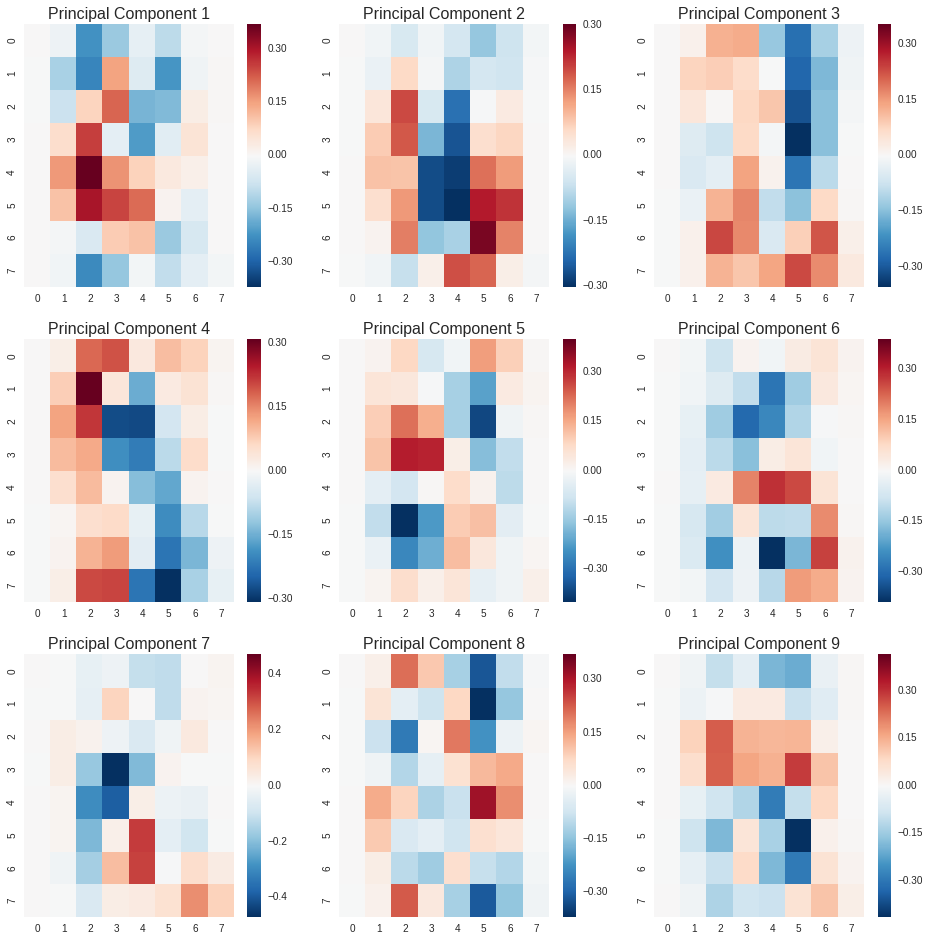

In [383]:
plotImages(reshapedComps[:9],
          lambda i : 'Principal Component %d' % (i+1) )

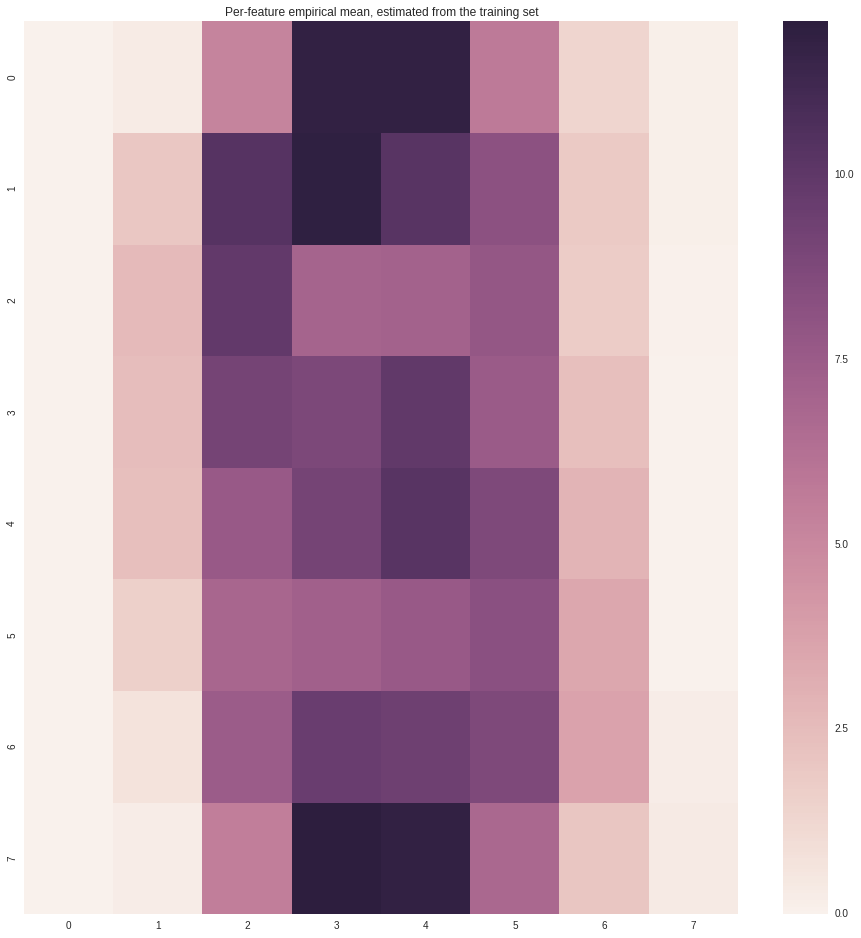

In [436]:
side = int(math.sqrt(len(pcaFull.mean_)))
ax = plotImages(pcaFull.mean_[np.newaxis].reshape((1,side,side)))
ax.set_title('Per-feature empirical mean, estimated from the training set')

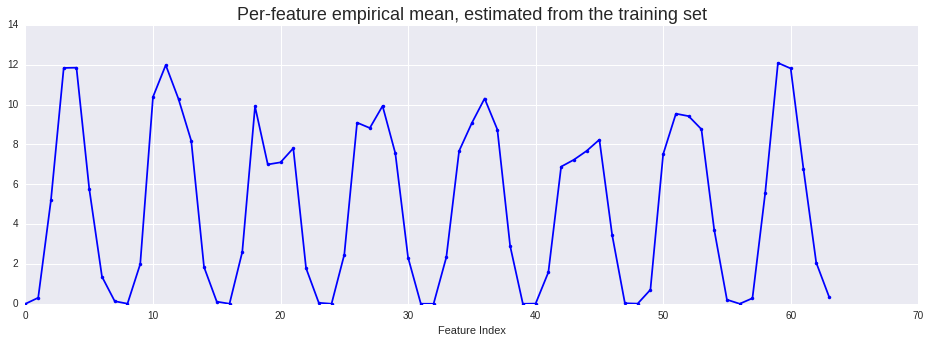

In [401]:
fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(5)
plt.clf()
plt.plot( np.arange(pcaFull.n_components_), pcaFull.mean_, 'b.-')
plt.title("Per-feature empirical mean, estimated from the training set", fontsize=18)
plt.xlabel('Feature Index')
plt.show()

### ========== Question 2.4 ==========

Now we want to make clear how these eigenvectors and the mean are used to approximate the data. `pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()` will transform the digit in row `idx` into pca space. Another way to think about this is that it will give you the coefficents to multiply each eigenvector by and to add to the mean digit such that you can reconstruct the digit.

For the digit with idx = 0 (which should itself be a zero), create 4 plots:
1. The original digit
1. The digit reconstructed using 1 principal component
1. The digit reconstructed using 2 principal components
1. The digit reconstructed using 5 principal components

In the plot titles show:
1. the number of principal components used
1. the percentage of variance explained by that number of principal components
1. the coefficients of each principal component rounded to nearest integer (tip, convert to integers to reduce print space), i.e. the PCA space vector.

Below the plots, comment on the result. Do the eigenvectors produce realistic data?

In [405]:
digitInPcaSpace = lambda pca, idx : pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()

In [406]:
digitInPcaSpace(pcaFull, 0).shape

(64,)

#### 1. original digit

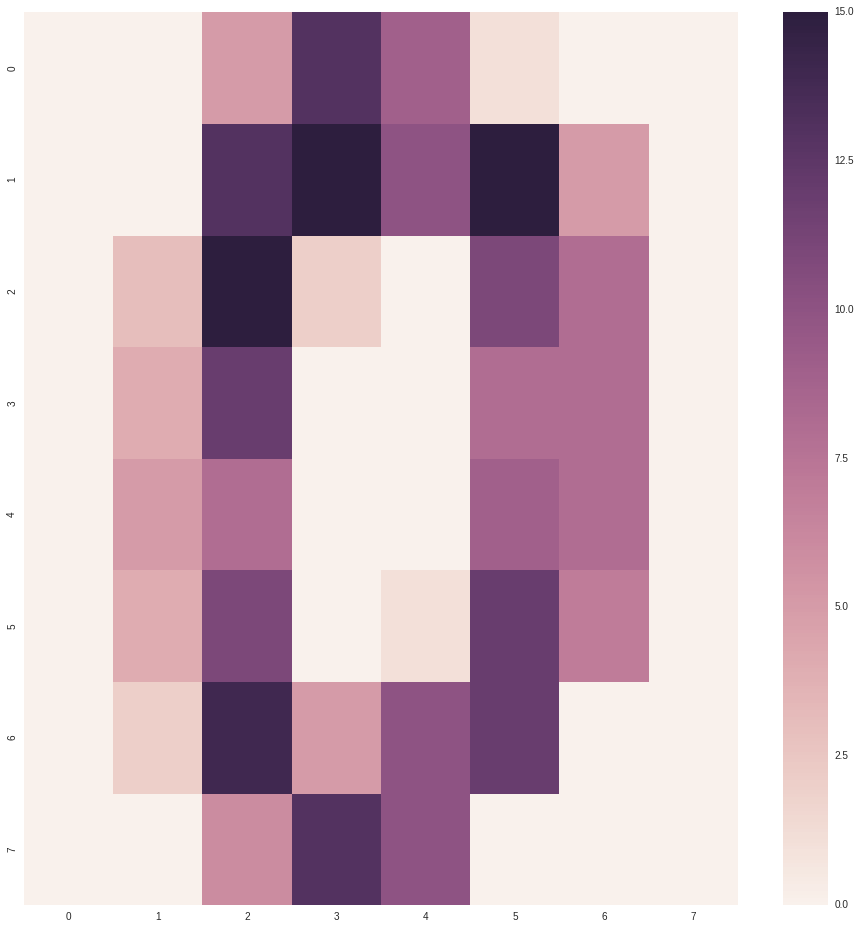

In [402]:
# Your code goes here
plotImages(digits.images[:1])

#### 2.

Below we are taking the transformed image in the PCA space and we are taking the dot product, effectively projecting on eigenvectors and finally we add the mean to get the fully reconstructed digit

In [425]:
def getReconstructedDigit(numOfComponents, digitIndex=0):
    multByEigenVectors = digitInPcaSpace(pcaFull, digitIndex)[:numOfComponents].\
            dot(pcaFull.components_[:numOfComponents])
    transformedDigit = multByEigenVectors + pcaFull.mean_
    return transformedDigit[np.newaxis].reshape(digits.images.shape[1:])

First it is worth reconstructing the digit using all of the 64 principal components to see if we can reconstruct the zero digit completely

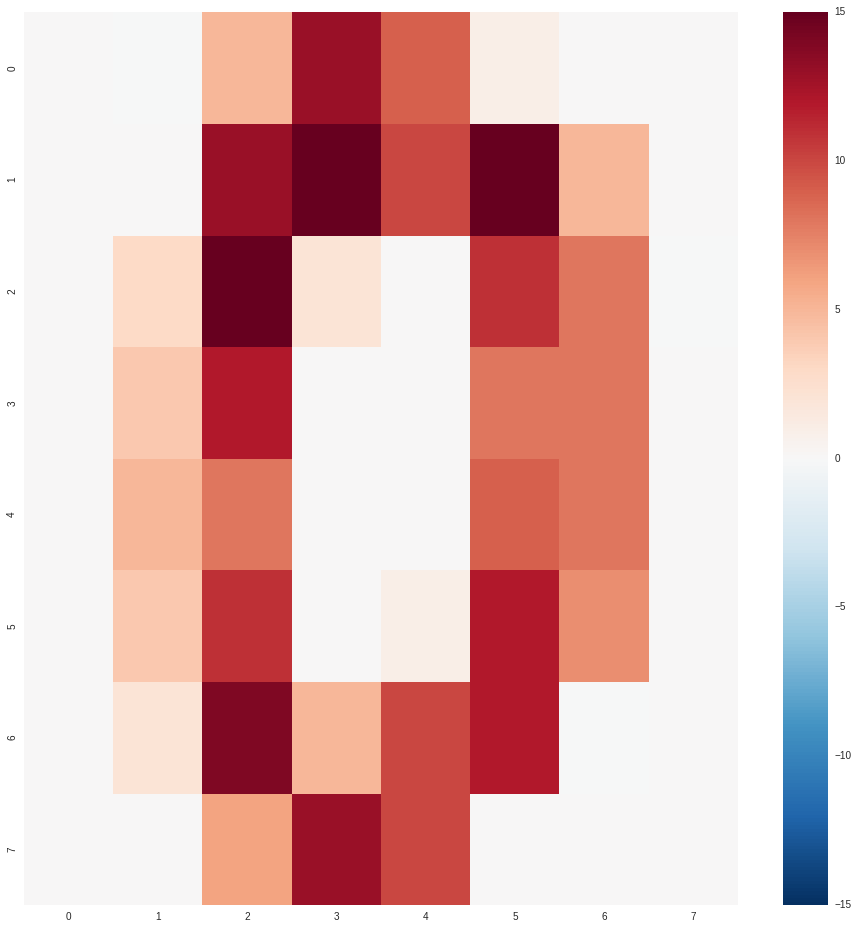

In [426]:
plotImages(
    getReconstructedDigit(numOfComponents=64)[np.newaxis]
)

That's good we have achieved a full reconstruction of the zero digit by using all the principal components

Now we can go ahead and check how the reconstruction looks for 5, 2 and 1 principal component as the exercise requires

In [444]:
getExplainedVariancePercentage = lambda pca, nComps : np.sum(pca.explained_variance_ratio_[:nComps])

In [479]:
getFormattedCoeffs = lambda i, n, pca : ", ".join( [ "%.2f" % d for d in digitInPcaSpace(pca, i)[:n] ] )

In [480]:
def plotReconstructedDigit(numOfPrincipalComps):
    ax = plotImages(
        getReconstructedDigit(numOfComponents=numOfPrincipalComps)[np.newaxis]
    )

    ax.set_title(
    """Variance Explained by %d Principal Components is %.2f%%
    and the coefficients of each principal component are: %s""" % \
        (numOfPrincipalComps,
         100*getExplainedVariancePercentage(pcaFull, numOfPrincipalComps),
        getFormattedCoeffs(0, numOfPrincipalComps, pcaFull)), fontsize=20)

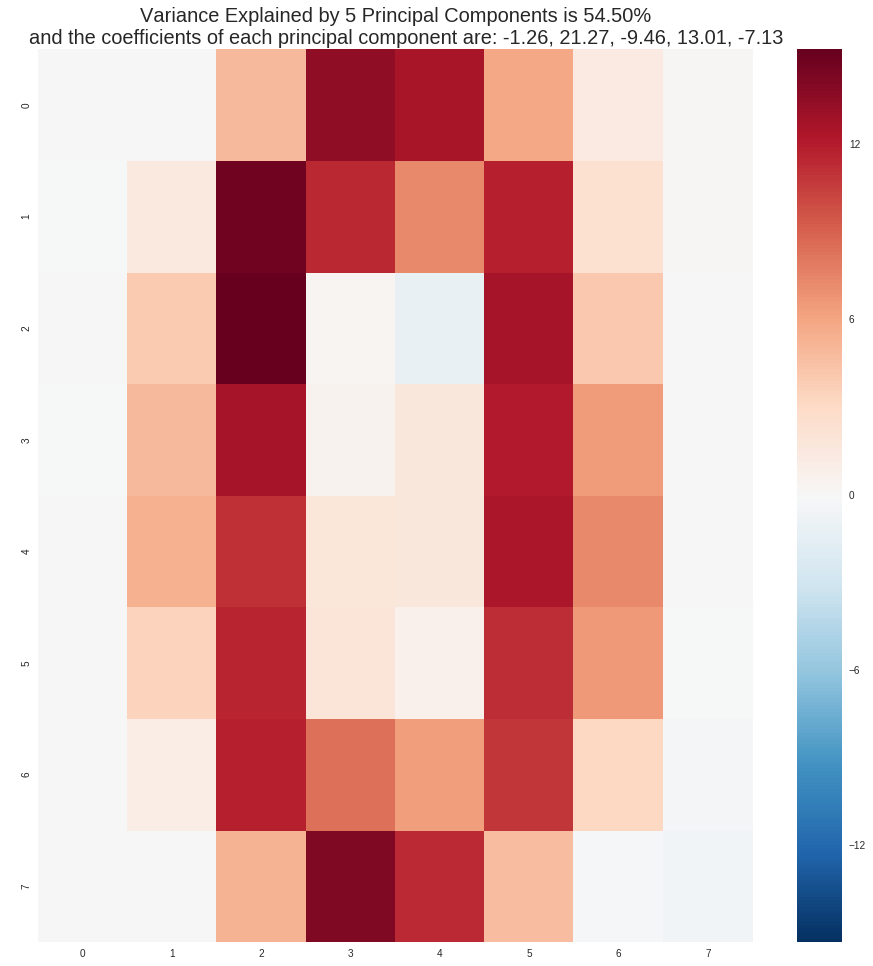

In [481]:
plotReconstructedDigit(numOfPrincipalComps = 5)

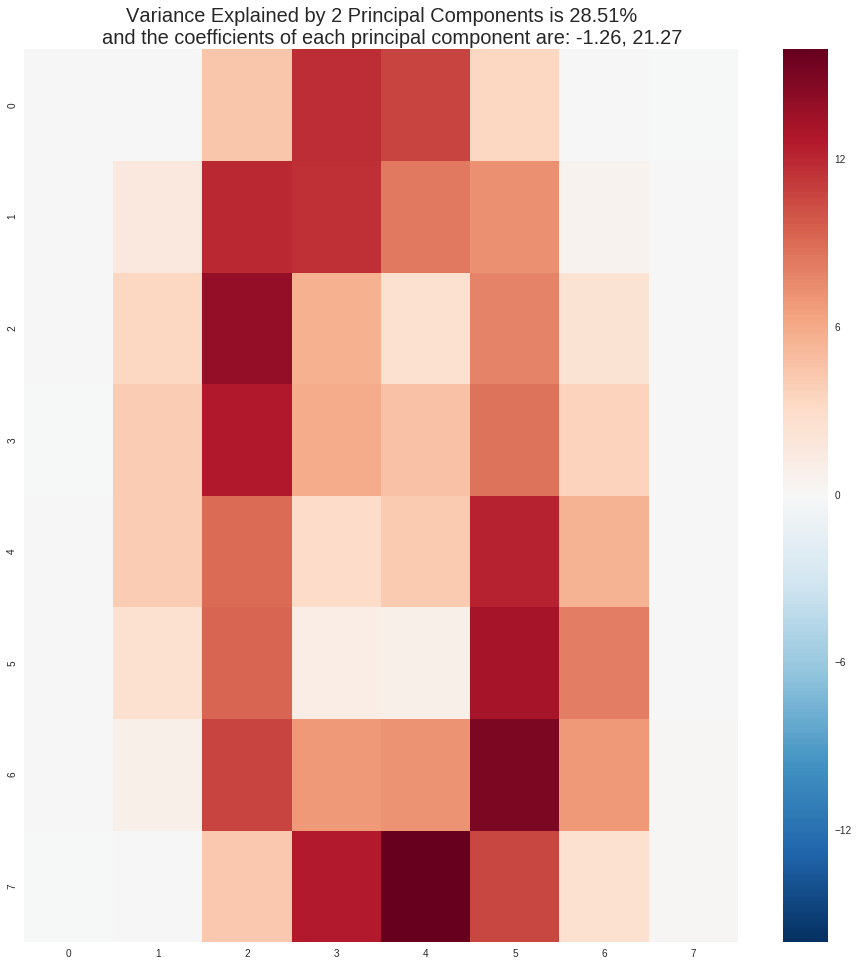

In [482]:
plotReconstructedDigit(numOfPrincipalComps = 2)

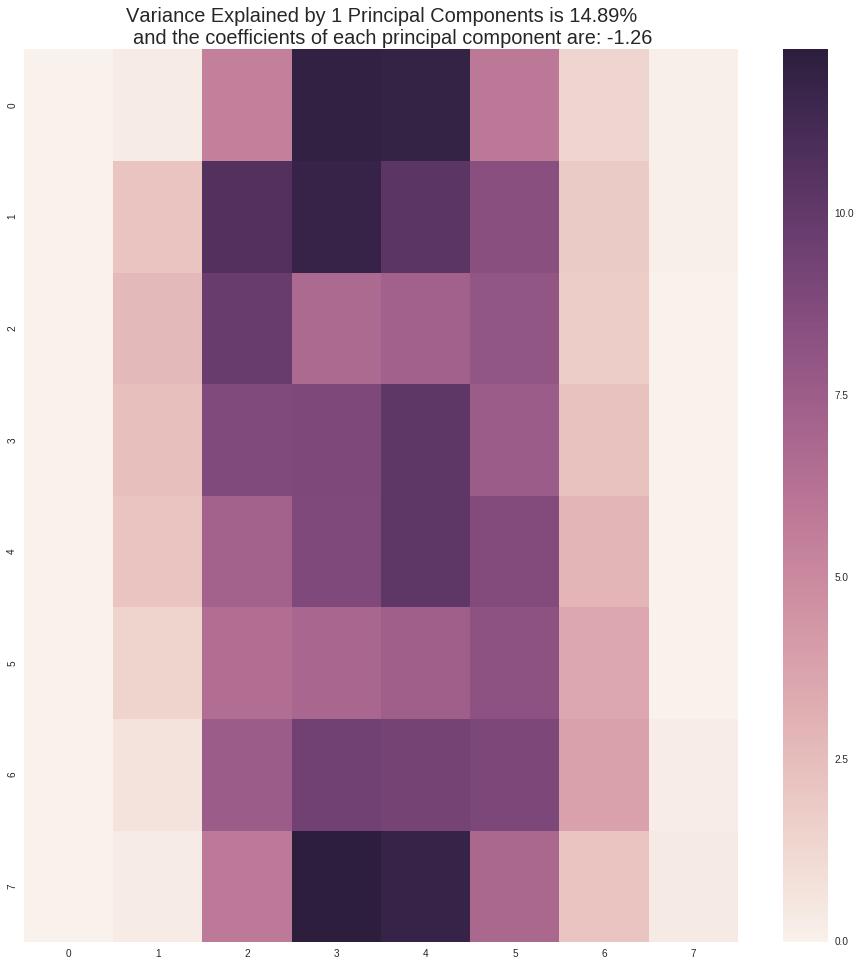

In [483]:
plotReconstructedDigit(numOfPrincipalComps = 1)

*Your answer goes here*

As a adjustment with bare eye yes indeed PCA produces very good results since zero still remains to be viewed as a zero with 2 or 5 or more principal components. Only in the extreme case of reducing the dimensions to only the first principal then the variance to be explained by that is small enough and therefore the reproduction is something that makes little sense to the bare eye.

### ========== Question 2.5 ==========

**Challenge question** 

Fit 4 models:
1. SVC with a linear kernel, no shrinking, and a random_state on digit data
1. SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)
1. Gaussian Naive Bayes Classifier on digit data
1. Gaussian Naive Bayes Classifier on pca transformed digit data (use the full 64 component pca above)

Use 5 fold cross validation and take the mean fold score as the result. Plot or print the results.

Below the code, explain why one classifier improved but the other did not!

In [55]:
# Your code goes here

*Your answer goes here*